The goal here is to train ONE RBM, then I will use similar code to do hyperparametric search.

In [1]:
# Activate project
using Pkg
Pkg.activate("/Users/alessiogiorlandino/Desktop/SAM/Project.toml")
Base.active_project()
# Resolve dependencies
Pkg.resolve()

  Activating project at `~/Desktop/SAM`


  No Changes to `~/Desktop/SAM/Project.toml`
  No Changes to `~/Desktop/SAM/Manifest.toml`


In [2]:
import Rfam, Infernal, Logomaker, FASTX
using Optimisers: Adam
using EllipsisNotation: (..)
using FillArrays: Falses
import Makie, CairoMakie
using Makie: @colorant_str
import SamApp
using LinearAlgebra
using Statistics

    CondaPkg Found dependencies: /Users/alessiogiorlandino/.julia/packages/Logomaker/DdglG/CondaPkg.toml


    CondaPkg Found dependencies: /Users/alessiogiorlandino/.julia/packages/PythonCall/dsECZ/CondaPkg.toml


    CondaPkg Found dependencies: /Users/alessiogiorlandino/.julia/packages/Logomaker/DdglG/CondaPkg.toml


    CondaPkg Found dependencies: /Users/alessiogiorlandino/.julia/packages/PythonCall/dsECZ/CondaPkg.toml


    CondaPkg Dependencies already up to date


In [3]:
using BioSequences: LongRNA, @rna_str
using Statistics: mean, std, cor
import JLD2

import RestrictedBoltzmannMachines as RBMs
import CudaRBMs, CenteredRBMs
using CudaRBMs: gpu, cpu
using CenteredRBMs: CenteredRBM, center, uncenter, center_from_data!
using RestrictedBoltzmannMachines: initialize!, RBM, xReLU, Potts, pcd!, Binary, log_pseudolikelihood, free_energy
using RBMsAnnealedImportanceSampling: aise, raise, logmeanexp, logstdexp, logvarexp

using MiniLoggers: global_logger, MiniLogger
global_logger(MiniLogger());

# Load sequence data from Rfam

In [4]:
cm = Infernal.cmfetch(Rfam.cm(), "RF00162")
natural_seed_stk = Infernal.esl_afetch(Rfam.seed(), "RF00162");
natural_seed_afa = Infernal.esl_reformat("afa", natural_seed_stk.out);
natural_seed_ids = FASTX.identifier.(FASTX.FASTA.Reader(open(natural_seed_afa.out)));

# Consensus secondary structure in WUSS format
seed_wuss = SamApp.stockholm_ss(natural_seed_stk.out)
seed_match_positions = findall(c -> c ≠ '.' && c ≠ '~', seed_wuss);

natural_hits_afa = Infernal.cmalign(Infernal.cmfetch(Rfam.cm(), "RF00162").out, Rfam.fasta_file("RF00162"); outformat="afa");
natural_hits_ids = FASTX.identifier.(FASTX.FASTA.Reader(open(natural_hits_afa.out)));

In [5]:
natural_seed_sequences_matchonly = map(FASTX.FASTA.Reader(open(natural_seed_afa.out))) do record
    FASTX.sequence(record)[seed_match_positions]
end

natural_hits_sequences_matchonly = map(FASTX.FASTA.Reader(open(natural_hits_afa.out))) do record
    filter(c -> !islowercase(c) && c ≠ '.', FASTX.sequence(record))
end

@assert only(unique(length.(natural_seed_sequences_matchonly))) == length(seed_match_positions) == 108
@assert only(unique(length.(natural_hits_sequences_matchonly))) == length(seed_match_positions) == 108

In [6]:
data_hits = SamApp.onehot(LongRNA{4}.(natural_hits_sequences_matchonly));

In [7]:
SamApp.seqlogo_entropic(reshape(mean(data_hits; dims=3), 5, 108)).fig

PythonCall.PyException: Python: UnicodeEncodeError: 'ascii' codec can't encode character '\u229f' in position 21: ordinal not in range(128)

In [8]:
#SamApp.rf00162_seed_taxonomy()

In [9]:
#SamApp.rf00162_hits_taxonomy()

# PCA

In [10]:
data_shape = size(data_hits)
data_flatten = reshape(data_hits, (data_shape[1]*data_shape[2], data_shape[3]))
data_flatten_cov = cov(data_flatten, dims=2)
cov_eigenval = eigvals(data_flatten_cov)
expl_ratio = cov_eigenval/sum(cov_eigenval)
ort_trasf = eigvecs(data_flatten_cov)

540×540 Matrix{Float64}:
 -0.00500608  -0.00373539   0.00116988   …  -0.024502     -0.0279693
 -0.00500608  -0.00373539   0.00116988       0.00386802    0.0372477
 -0.00500608  -0.00373539   0.00116988      -0.024368     -0.0346185
 -0.00500608  -0.00373539   0.00116988       0.0450736     0.0258592
 -0.00500608  -0.00373539   0.00116988      -7.56379e-5   -0.000531111
  0.0250623    0.0397066   -0.0148391    …  -0.0204701    -0.068204
  0.0250623    0.0397066   -0.0148391        0.00704773   -0.0224542
  0.0250623    0.0397066   -0.0148391       -0.0891822    -0.043177
  0.0250623    0.0397066   -0.0148391        0.102815      0.134019
  0.0250623    0.0397066   -0.0148391       -0.000214233  -0.000195645
  ⋮                                      ⋱                
 -0.15687     -0.0205068   -0.0538109       -0.0236288    -0.0134448
 -0.15687     -0.0205068   -0.0538109       -0.0325534    -0.05601
 -0.15687     -0.0205068   -0.0538109       -0.0538271    -0.0315493
 -0.15687     -0.020

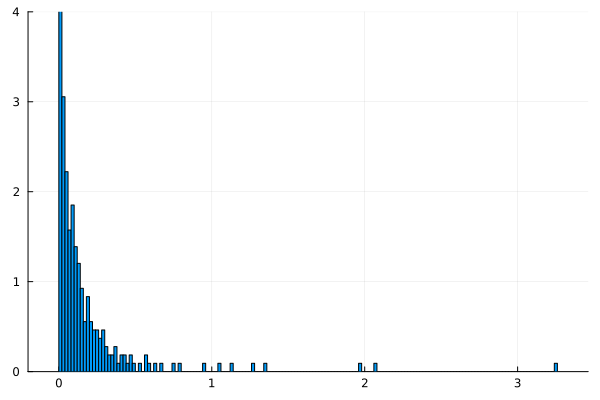

In [11]:
function set_negative_to_zero(arr)
    for i in 1:length(arr)
        if arr[i] < 0
            arr[i] = 0
        end
    end
    return arr
end

cov_eigenval = set_negative_to_zero(cov_eigenval)
using Plots
histogram(cov_eigenval, normalize=:pdf, ylim=(0,4), legend=false)
# add upper threshold for Marcenko-Pastur Distribution

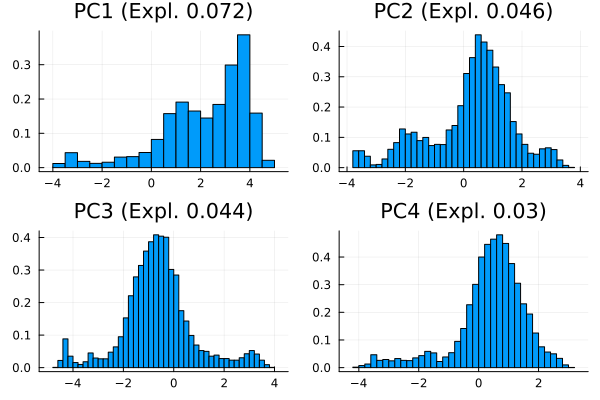

In [12]:
# First Component Histogram 
data_flatten_rot = transpose(ort_trasf)*data_flatten
pc1 = data_flatten_rot[end, :]
p1=histogram(pc1, normalize=:pdf, title=("PC1 (Expl. $(round(expl_ratio[end], digits=3)))"))


pc2 = data_flatten_rot[end-1, :]
p2=histogram(pc2, normalize=:pdf, title=("PC2 (Expl. $(round(expl_ratio[end-1], digits=3)))"))

pc3 = data_flatten_rot[end-2, :]
p3=histogram(pc3, normalize=:pdf, title=("PC3 (Expl. $(round(expl_ratio[end-2], digits=3)))"))

pc4 = data_flatten_rot[end-3, :]
p4=histogram(pc4, normalize=:pdf, title=("PC4 (Expl. $(round(expl_ratio[end-3], digits=3)))"))


plot(p1, p2, p3, p4, layout=(2,2), legend=false)

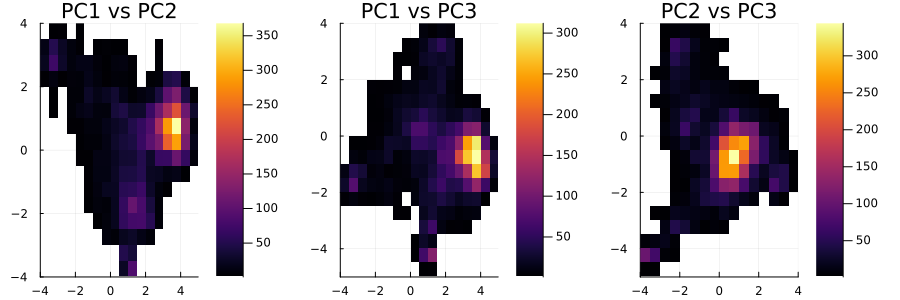

In [13]:
p1=histogram2d(pc1, pc2, title="PC1 vs PC2")
p2=histogram2d(pc1, pc3, title="PC1 vs PC3")
p3=histogram2d(pc2, pc3, title="PC2 vs PC3")

plot(p1, p2, p3, layout=(1,3), legend=false, size=(900,300))

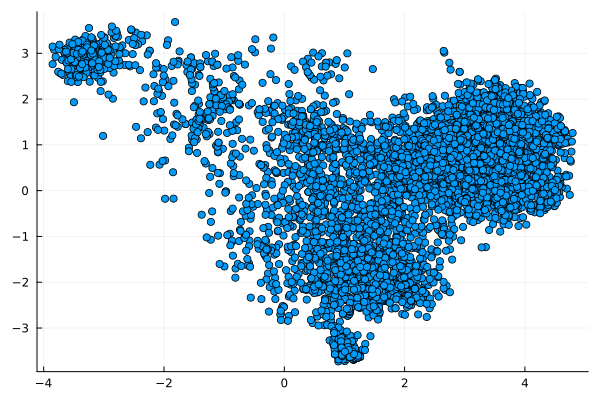

In [14]:
scatter(pc1, pc2, legend=false)

# Train RBM

In [15]:
# Sparsity parameter, as defined in Tubiana, RM, 2017 PRL (denoted \hat{p} there)
# This is smaller for sparser weights
function sparsity(rbm)
    num = sum(rbm.w.^2, dims=1:ndims(rbm.visible)).^2
    den = sum(rbm.w.^4, dims=1:ndims(rbm.visible))
    return sum(num ./ den) / length(rbm.w)
end

sparsity (generic function with 1 method)

In [16]:
logfile = open("log_dReLu64.txt", "w+")
#write(logfile, "#Epoch lpl")

function callback(; rbm, iter, kw...)
    if iszero(iter % 100)
        Δt = @elapsed (lpl = mean(log_pseudolikelihood(rbm, data)))
        @info iter lpl Δt
        write(logfile, "$iter $lpl \n")
    end

end



callback (generic function with 1 method)

In [17]:
data = data_hits;
n_hidden = 64
rbm = center(RBM(Potts((5, 108)), xReLU((n_hidden,)), zeros(5, 108, n_hidden)));
initialize!(rbm, data);

In [18]:
pcd!(
    rbm, data; 
    batchsize=256, iters=10000, steps=10, optim=Adam(1f-3), l2l1_weights=1f-3,
    vm=data[.., rand(1:size(data)[end], 256)], callback
);

close(logfile)

[2023-04-20 14:48:17] Info: 100 lpl = -0.719440281457392, Δt = 2.446196916


[2023-04-20 14:48:34] Info: 200 lpl = -0.6052358314508468, Δt = 0.470188542


[2023-04-20 14:48:53] Info: 300 lpl = -0.5342043271170606, Δt = 0.572101


[2023-04-20 14:49:15] Info: 400 lpl = -0.5201919103585851, Δt = 0.555499208


[2023-04-20 14:49:28] Info: 500 lpl = -0.47757469498614236, Δt = 0.444462083


[2023-04-20 14:49:46] Info: 600 lpl = -0.4754699762477665, Δt = 0.692455792


[2023-04-20 14:50:06] Info: 700 lpl = -0.45798121930606395, Δt = 0.4681865


[2023-04-20 14:50:24] Info: 800 lpl = -0.43775771054643675, Δt = 0.622191125


[2023-04-20 14:50:44] Info: 900 lpl = -0.44706051506899064, Δt = 0.63543925


[2023-04-20 14:51:08] Info: 1000 lpl = -0.43848534195587135, Δt = 0.950063166


[2023-04-20 14:51:32] Info: 1100 lpl = -0.4253811809474705, Δt = 1.043450333


[2023-04-20 14:52:01] Info: 1200 lpl = -0.419357687875653, Δt = 1.018070666


In [ ]:
using DelimitedFiles
data = readdlm("log_dReLu64.txt")
iter= data[:, 1]
lpl = data[:, 2]
plot(iter, lpl, legend=false)
xlabel!("Epoch")
ylabel!("Log-Pseudo-Likelihood")

# Saving Params

In [ ]:
wfile = open("weights_xRelu64.txt", "w+")
write(wfile, "$(RBM(rbm).w)")
close(wfile)

# Some Statistics of W

In [ ]:
using LaTeXStrings
weights = vec(RBM(rbm).w)
histogram(weights , normalize=:pdf, legend=false)
xlabel!(L"w_{ij}")
ylabel!(L"p(w_{ij})")

In quadratic case: 
$E_{eff-interaction} = -1/2 \sum_{i,j}\left( \sum_{\mu} w_{i\mu} w_{j\mu}\right)v_iv_j \rightarrow  J_{ij}= \sum_{\mu} w_{i\mu} w_{j\mu}$

Even though we are not in gaussian case, let's explore $J_{ij}$.

In [ ]:
w_shape = size(RBM(rbm).w) 
w = reshape(RBM(rbm).w, (w_shape[1]*w_shape[2],w_shape[3]))
J = vec(w*transpose(w))
histogram(J , normalize=:pdf, legend=false, xlim=(-0.07,0.07))
xlabel!(L"J_{ij}")
ylabel!(L"p(J_{ij})")


# Sampling a Representation of the Sequences

In [ ]:
import RestrictedBoltzmannMachines
hidden_data = zeros(n_hidden, data_shape[3])
for i in 1:data_shape[3]
    hidden_data[:,i]=RestrictedBoltzmannMachines.sample_h_from_v(rbm, data_hits[:,:,i]) 
end


In [ ]:
hidden_cov = cov(hidden_data, dims=2)
h_cov_eigenval = eigvals(hidden_cov)
h_expl_ratio = h_cov_eigenval/sum(h_cov_eigenval)
h_ort_trasf = eigvecs(hidden_cov)
h_cov_eigenval = set_negative_to_zero(cov_eigenval)
histogram(h_cov_eigenval, normalize=:pdf, legend=false, ylim=(0,4))


In [ ]:
hidden_data_rot = transpose(h_ort_trasf)*hidden_data
hpc1 = hidden_data_rot[end, :]
hp1=histogram(hpc1, normalize=:pdf, title=("PC1 (Expl. $(round(h_expl_ratio[end], digits=3)))"))


hpc2 = hidden_data_rot[end-1, :]
hp2=histogram(hpc2, normalize=:pdf, title=("PC2 (Expl. $(round(h_expl_ratio[end-1], digits=3)))"))

hpc3 = hidden_data_rot[end-2, :]
hp3=histogram(hpc3, normalize=:pdf, title=("PC3 (Expl. $(round(h_expl_ratio[end-2], digits=3)))"))

hpc4 = hidden_data_rot[end-3, :]
hp4=histogram(hpc4, normalize=:pdf, title=("PC4 (Expl. $(round(h_expl_ratio[end-3], digits=3)))"))


plot(hp1, hp2, hp3, hp4, layout=(2,2), legend=false)

In [ ]:
p1=histogram2d(hpc1, hpc2, title="PC1 vs PC2")
p2=histogram2d(hpc1, hpc3, title="PC1 vs PC3")
p3=histogram2d(hpc2, hpc3, title="PC2 vs PC3")

plot(p1, p2, p3, layout=(1,3), legend=false, size=(900,300))

In [ ]:
p1 = scatter(pc1, pc2, title="Visible PC1 vs PC2", legend=false)
p2 = scatter(hpc1, hpc2, title="Hidden PC1 vs PC2", legend=false)

plot(p1, p2, layout=(1,2), legend=false, size=(800,300))

In [ ]:
p1 = scatter(pc1, pc3, title="Visible PC1 vs PC3", legend=false)
p2 = scatter(hpc1, hpc3, title="Hidden PC1 vs PC3", legend=false)

plot(p1, p2, layout=(1,2), legend=false, size=(800,300))

In [ ]:
p1 = scatter(pc2, pc3, title="Visible PC2 vs PC3", legend=false)
p2 = scatter(hpc2, hpc3, title="Hidden PC2 vs PC3", legend=false)

plot(p1, p2, layout=(1,2), legend=false, size=(800,300))